#  Genome clustering characterization via 5-mer abundance vectors

You can use either `search.characterize_catlas_regions` to extract 5-mer vectors
from a partitioning of the catlas, OR `utils/chunk-genomes.py` to build 5-mer vectors
from known genomes.

Once you have a vec file (produced e.g. like so
```
python -m search.characterize_catlas_regions twofoo_k31_r1 twofoo.vec
```
or like so:
```
scripts/chunk-genomes-to-vectors.py podar-ref/[01234].fa -o podar5.vec
```

now cluster it like so,

```
scripts/cluster-vectors.py podar5.vec -o podar5.vec.cluster
```

The `podar5.vec` file can then be fed into this notebook as 'filename', below.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import pandas as pd
import pickle
import itertools
import sourmash_lib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import palettable as pal

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


In [2]:
filename = 'podar5.vec'

## Load data

In [3]:
data = numpy.load(filename)
print(data.shape)

(1674, 1024)


In [4]:
# load the k=31 MinHashes for identification, and the mapping between node IDs and 
# data index.
node_id_to_group_idx = pickle.load(open(filename + '.node_ids', 'rb'))
group_ident = pickle.load(open(filename + '.node_mh', 'rb'))

## Assign labels to data based on minhash searching

In [5]:
import glob

source_genome_mh = {}
genome_mh_name = {}
for label, i in enumerate(glob.glob('podar-ref/*.fa.sig')):
    ss = sourmash_lib.load_one_signature(i)
    source_genome_mh[label] = ss.minhash
    genome_mh_name[label] = ss.name()
    
print('loaded {} sigs'.format(len(source_genome_mh)))

loaded 64 sigs


In [6]:
# build a 'label' array and then fill it in by asking which nodes -> which minhashes
label_arr = np.zeros(max(node_id_to_group_idx.values()) + 1)

# label node bins that are least 90% contained by exactly one minhash
MIN_CONTAINMENT=0.9
labeled_bins = 0
for node_id, vec_mh in group_ident.items():
    n_found = 0
    found_label = None

    for label, genome_mh in source_genome_mh.items():
        if vec_mh and vec_mh.contained_by(genome_mh) > 0.9:
            found_label = label
            n_found += 1
            
    if n_found == 1:
        assert found_label != None
        idx = node_id_to_group_idx[node_id]
        label_arr[idx] = found_label + 1
        labeled_bins += 1

print('labeled {} nodes, of {} ({:.1f}%)'.format(labeled_bins,
                                                len(group_ident),
                                                labeled_bins / len(group_ident) * 100))
print('found {} labels total:'.format(len(set(label_arr)) - 1))

for label in set(label_arr):
    if label:
        label_name = genome_mh_name[label-1]
        print('\t', label, label_name)

labeled 1673 nodes, of 1674 (99.9%)
found 5 labels total:
	 1.0 CP001472.1 Acidobacterium capsulatum ATCC 51196, complete genome
	 2.0 CP001941.1 Aciduliprofundum boonei T469, complete genome
	 35.0 AE015928.1 Bacteroides thetaiotaomicron VPI-5482, complete genome
	 13.0 CP001071.1 Akkermansia muciniphila ATCC BAA-835, complete genome
	 24.0 AE000782.1 Archaeoglobus fulgidus DSM 4304, complete genome


In [7]:
print('compacting labels')
label_mapping = {}
new_label_n = 1
for label in set(label_arr):
    if label:
        label_mapping[label] = new_label_n
        new_label_n += 1
        
for idx in range(len(label_arr)):
    if label_arr[idx]:
        label_arr[idx] = label_mapping[label_arr[idx]]
        
print(min(label_arr), max(label_arr))

compacting labels
0.0 5.0


In [8]:
# build a color palette for the labels; make unlabeled 'white'.
palette = sns.color_palette('bright', new_label_n + 1)
palette[0] = (1,1,1)

colors = [palette[int(x)] for x in label_arr ]
print(len(colors), len(label_arr), new_label_n)
print(set(colors))

1674 1674 6
{(1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0), (0.9098039215686274, 0.0, 0.043137254901960784), (0.5411764705882353, 0.16862745098039217, 0.8862745098039215), (0.011764705882352941, 0.9294117647058824, 0.22745098039215686), (1, 1, 1)}


## Load a PCA, tSNE, and hdbscan clustering

crreated outside the notebook with `scripts/cluster-vectors.py`

In [9]:
(data_pca, t, h) = pickle.load(open(filename + '.cluster', 'rb'))

## Plot PCA and tSNE clusters with predicted labels

Here, labels are predicted against the known ground truth using sourmash (see assign labels, above)

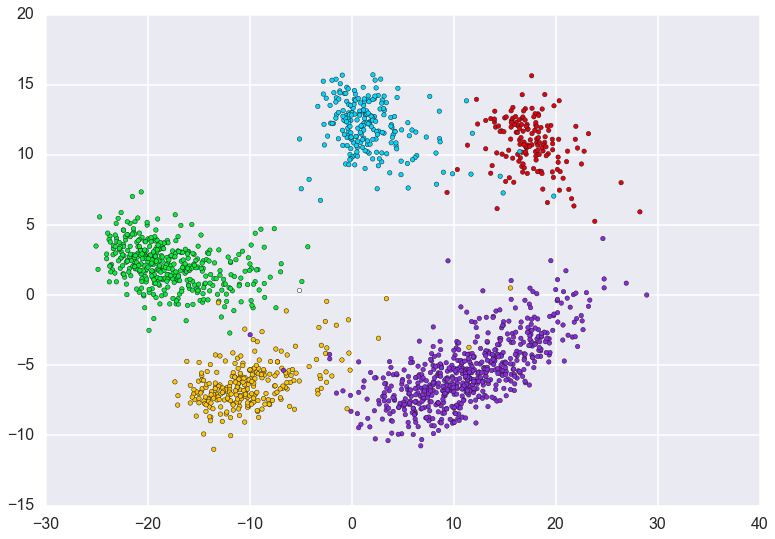

In [10]:
pca_df = pd.DataFrame(data_pca)
pyplot.scatter(pca_df[0], pca_df[1], c=colors)

1674


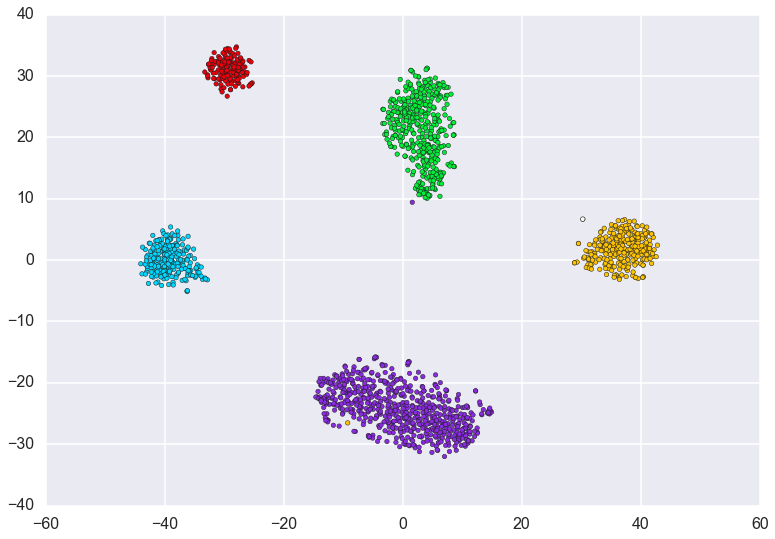

In [11]:
df = pd.DataFrame(t)
df.columns=['t1','t2']
pyplot.scatter(df.t1, df.t2, c=colors)

#pyplot.savefig('/tmp/twofoo.cluster.png')
print(len(t))

In [12]:
print('hdbscan produced {} clusters'.format(max(h) + 1))

hdbscan produced 5 clusters


## Build a confusion matrix with known good labels vs clusters

This is a way to evaluate the de novo clustering vs labeling.

Swiped from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [13]:
# note, for palette/display reasons labels are 0 if unlabeled in label_arr;
# for the confusion matrix, and to match the output of the clustering alg,
# we need to set the values to -1 if unlabeled.
label_arr2 = numpy.array(label_arr)
for i in range(len(label_arr2)):
    if label_arr2[i] == 0:
        label_arr2[i] = -1

cnf = confusion_matrix(label_arr2, h)

In [14]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#    tick_marks = np.arange(len(classes))
#    plt.xticks(tick_marks, classes, rotation=45)
#    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Interpreting the confusion matrix

Here, we are looking for large blocks, single ones per rows/columns. Where there are multiple blocks in a single column, that indicates clusters that have been merged in the prediction. (For the twofoo data set, for example, this will happen with the strain variants that cannot be separated. That's to be expected.)

CTB does not underrstand why there is a true label '0' and not a true label '1'.

Confusion matrix, without normalization
[[  0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0 413   0   0   0   0]
 [  0   0   0   0 149   0   0]
 [  0 625   1   0   0   0   0]
 [  0   2   0 265   0   0   0]
 [  0   0   0   0   0 218   0]]


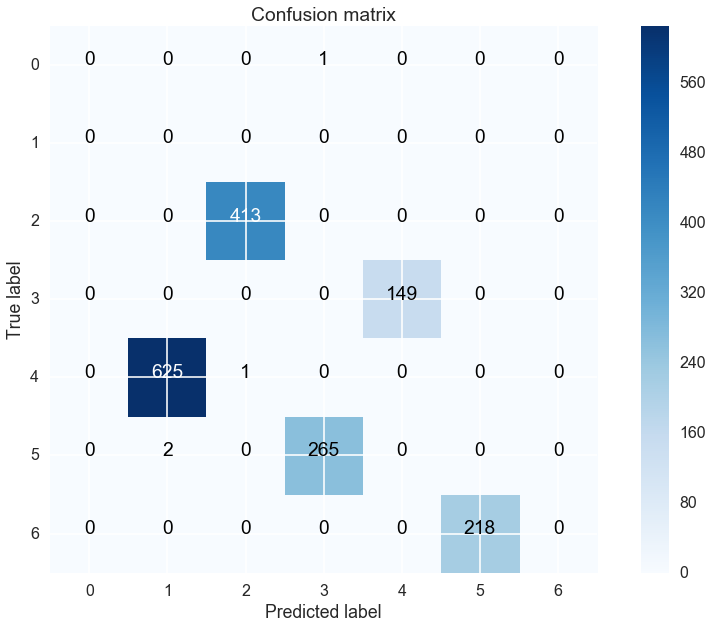

In [15]:
plot_confusion_matrix(cnf)